In [ ]:
import numpy as np
from keras.datasets import fashion_mnist
def get_fa_mnist(flatten=True):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if flatten:
        x_train = x_train.reshape(x_train.shape[0], 28*28)
        x_test = x_test.reshape(x_test.shape[0], 28*28)
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    return (x_train, y_train), (x_test, y_test)

In [ ]:
import numpy as np
class Activate:
    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha*z)
    @staticmethod
    def leaky_relu_der(z, alpha=0.01):
        dz = np.ones_like(z)
        dz[z < 0] = alpha
        return dz
    @staticmethod
    def soft(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [ ]:
class FNN:
    def __init__(self, input_size, hidden_layers, output_size):
        np.random.seed(42)
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}
        for i in range(len(self.layers)-1):
            limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
            self.weights['W'+str(i+1)] = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            self.biases['b'+str(i+1)] = np.zeros((1, self.layers[i+1]))
    def forw(self, X):
      self.cache = {'A0': X}
      L = len(self.layers)-1
      for l in range(1, L):
          Z = np.dot(self.cache['A'+str(l-1)], self.weights['W'+str(l)]) + self.biases['b'+str(l)]
          A = Activate.leaky_relu(Z)
          self.cache['Z'+str(l)] = Z
          self.cache['A'+str(l)] = A
      ZL = np.dot(self.cache['A'+str(L-1)], self.weights['W'+str(L)]) + self.biases['b'+str(L)]
      AL = Activate.soft(ZL)
      self.cache['Z'+str(L)] = ZL
      self.cache['A'+str(L)] = AL
      return AL
    def cross_ent(self,Y_pred, Y_true):
      m = Y_true.shape[0]
      return np.mean(-np.sum(Y_true * np.log(Y_pred + 1e-8), axis=1))
    def backw(self, Y_true, learning_rate=0.01):
      grads_w = {}
      grads_b = {}
      L = len(self.layers)-1
      m = Y_true.shape[0]
      dZ = self.cache['A'+str(L)] - Y_true
      grads_w['dW'+str(L)] = np.dot(self.cache['A'+str(L-1)].T, dZ)/m
      grads_b['db'+str(L)] = np.sum(dZ, axis=0, keepdims=True)/m
      dA_prev = np.dot(dZ, self.weights['W'+str(L)].T)
      for l in reversed(range(1, L)):
          dZ = dA_prev * Activate.leaky_relu_der(self.cache['Z'+str(l)])
          grads_w['dW'+str(l)] = np.dot(self.cache['A'+str(l-1)].T, dZ)/m
          grads_b['db'+str(l)] = np.sum(dZ, axis=0, keepdims=True)/m
          if l > 1:
              dA_prev = np.dot(dZ, self.weights['W'+str(l)].T)
      for l in range(1, L+1):
          self.weights['W'+str(l)] -= learning_rate * grads_w['dW'+str(l)]
          self.biases['b'+str(l)] -= learning_rate * grads_b['db'+str(l)]
    def train(self, X_train, Y_train, X_test, Y_test, lr=0.005, epochs=15):
      for epoch in range(epochs):
        Y_pred = self.forw(X_train)
        loss = self.cross_ent(Y_pred, Y_train)
        self.backw(Y_train, learning_rate=lr)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
      Y_pred_test = self.forw(X_test)
      accuracy = np.mean(np.argmax(Y_pred_test, axis=1) == np.argmax(Y_test, axis=1))
      print(f"Test Accuracy: {accuracy*100:.2f}%")

In [ ]:
import numpy as np
class Activations:
    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)

    @staticmethod
    def relu_der(Z):
        return (Z > 0).astype(float)

    @staticmethod
    def softmax(Z):
        exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
def categorical_cross_entropy(pred, true):
    m = true.shape[0]
    return -np.sum(true * np.log(pred + 1e-8)) / m
class NeuralNet:
    def __init__(self, input_dim, hidden_layers, output_dim, optimizer='sgd', lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        np.random.seed(99)
        self.layers = [input_dim] + hidden_layers + [output_dim]
        self.weights = {}
        self.biases = {}
        self.opt = optimizer.lower()
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.time_step = 0
        for i in range(len(self.layers)-1):
            limit = np.sqrt(6 / (self.layers[i] + self.layers[i+1]))
            self.weights[f"W{i+1}"] = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            self.biases[f"b{i+1}"] = np.zeros((1, self.layers[i+1]))
        self.velocity_w = {k: np.zeros_like(v) for k,v in self.weights.items()}
        self.velocity_b = {k: np.zeros_like(v) for k,v in self.biases.items()}
        self.sqr_w = {k: np.zeros_like(v) for k,v in self.weights.items()}
        self.sqr_b = {k: np.zeros_like(v) for k,v in self.biases.items()}
    def forward(self, X):
        store = {'A0': X}
        L = len(self.layers) - 1
        for l in range(1, L):
            Z = np.dot(store[f"A{l-1}"], self.weights[f"W{l}"]) + self.biases[f"b{l}"]
            A = Activations.relu(Z)
            store[f"Z{l}"], store[f"A{l}"] = Z, A

        ZL = np.dot(store[f"A{L-1}"], self.weights[f"W{L}"]) + self.biases[f"b{L}"]
        AL = Activations.softmax(ZL)
        store[f"Z{L}"], store[f"A{L}"] = ZL, AL
        return AL, store
    def backward(self, Y_pred, Y_true, store):
        grads = {}
        L = len(self.layers)-1
        m = Y_true.shape[0]
        dZ = Y_pred - Y_true
        grads[f"dW{L}"] = np.dot(store[f"A{L-1}"].T, dZ)/m
        grads[f"db{L}"] = np.sum(dZ, axis=0, keepdims=True)/m
        dA_prev = np.dot(dZ, self.weights[f"W{L}"].T)
        for l in reversed(range(1, L)):
            dZ = dA_prev * Activations.relu_der(store[f"Z{l}"])
            grads[f"dW{l}"] = np.dot(store[f"A{l-1}"].T, dZ)/m
            grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True)/m
            if l > 1:
                dA_prev = np.dot(dZ, self.weights[f"W{l}"].T)
        return grads
    def update_params(self, grads):
        self.time_step += 1
        for l in range(1, len(self.layers)):
            Wk, bk = f"W{l}", f"b{l}"
            dW, db = grads[f"dW{l}"], grads[f"db{l}"]

            if self.opt == 'sgd':
                self.weights[Wk] -= self.lr * dW
                self.biases[bk] -= self.lr * db
            elif self.opt == 'momentum':
                self.velocity_w[Wk] = self.beta1*self.velocity_w[Wk] + (1-self.beta1)*dW
                self.velocity_b[bk] = self.beta1*self.velocity_b[bk] + (1-self.beta1)*db
                self.weights[Wk] -= self.lr * self.velocity_w[Wk]
                self.biases[bk] -= self.lr * self.velocity_b[bk]
            elif self.opt == 'nesterov':
              vW_prev = self.velocity_w[Wk]
              vb_prev = self.velocity_b[bk]
              self.velocity_w[Wk] = self.beta1 * self.velocity_w[Wk] - self.lr * dW
              self.velocity_b[bk] = self.beta1 * self.velocity_b[bk] - self.lr * db
              self.weights[Wk] += -self.beta1 * vW_prev + (1 + self.beta1) * self.velocity_w[Wk]
              self.biases[bk]  += -self.beta1 * vb_prev + (1 + self.beta1) * self.velocity_b[bk]
            elif self.opt == 'rmsprop':
                self.sqr_w[Wk] = self.beta2*self.sqr_w[Wk] + (1-self.beta2)*(dW**2)
                self.sqr_b[bk] = self.beta2*self.sqr_b[bk] + (1-self.beta2)*(db**2)
                self.weights[Wk] -= self.lr * dW / (np.sqrt(self.sqr_w[Wk])+self.eps)
                self.biases[bk] -= self.lr * db / (np.sqrt(self.sqr_b[bk])+self.eps)
            elif self.opt == 'adam':
                self.velocity_w[Wk] = self.beta1*self.velocity_w[Wk] + (1-self.beta1)*dW
                self.velocity_b[bk] = self.beta1*self.velocity_b[bk] + (1-self.beta1)*db
                self.sqr_w[Wk] = self.beta2*self.sqr_w[Wk] + (1-self.beta2)*(dW**2)
                self.sqr_b[bk] = self.beta2*self.sqr_b[bk] + (1-self.beta2)*(db**2)
                vW_corr = self.velocity_w[Wk]/(1-self.beta1**self.time_step)
                vb_corr = self.velocity_b[bk]/(1-self.beta1**self.time_step)
                sW_corr = self.sqr_w[Wk]/(1-self.beta2**self.time_step)
                sb_corr = self.sqr_b[bk]/(1-self.beta2**self.time_step)
                self.weights[Wk] -= self.lr * vW_corr / (np.sqrt(sW_corr)+self.eps)
                self.biases[bk] -= self.lr * vb_corr / (np.sqrt(sb_corr)+self.eps)
            elif self.opt == 'nadam':
                 self.velocity_w[Wk] = self.beta1*self.velocity_w[Wk] + (1-self.beta1)*dW
                 self.velocity_b[bk] = self.beta1*self.velocity_b[bk] + (1-self.beta1)*db
                 m_hat_b = self.velocity_b[bk] / (1 - self.beta1**self.time_step)
                 vW_hat = (self.velocity_w[Wk]*self.beta1 + (1-self.beta1)*dW) / (1-self.beta1**self.time_step)
                 vb_hat = (self.velocity_b[bk]*self.beta1 + (1-self.beta1)*db) / (1-self.beta1**self.time_step)
                 self.sqr_w[Wk] = self.beta2*self.sqr_w[Wk] + (1-self.beta2)*(dW**2)
                 self.sqr_b[bk] = self.beta2*self.sqr_b[bk] + (1-self.beta2)*(db**2)
                 sW_corr = self.sqr_w[Wk]/(1-self.beta2**self.time_step)
                 sb_corr = self.sqr_b[bk]/(1-self.beta2**self.time_step)
                 self.weights[Wk] -= self.lr * vW_hat / (np.sqrt(sW_corr)+self.eps)
                 self.biases[bk] -= self.lr * vb_hat / (np.sqrt(sb_corr)+self.eps)
    def train(self, X_train, Y_train, X_test, Y_test, epochs=20, batch_size=64):
        m = X_train.shape[0]
        for ep in range(epochs):
            perm = np.random.permutation(m)
            X_shuf, Y_shuf = X_train[perm], Y_train[perm]
            for i in range(0, m, batch_size):
                Xb, Yb = X_shuf[i:i+batch_size], Y_shuf[i:i+batch_size]
                Y_pred, store = self.forward(Xb)
                grads = self.backward(Y_pred, Yb, store)
                self.update_params(grads)
            Y_pred_train, _ = self.forward(X_train)
            train_loss = categorical_cross_entropy(Y_pred_train, Y_train)
            train_acc = np.mean(
            np.argmax(Y_pred_train, axis=1) == np.argmax(Y_train, axis=1)
            )
            Y_pred_test, _ = self.forward(X_test)
            val_loss = categorical_cross_entropy(Y_pred_test, Y_test)
            val_acc = np.mean(
                np.argmax(Y_pred_test, axis=1) == np.argmax(Y_test, axis=1)
            )
            wandb.log({
                "epoch": ep + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc
            })

            print(
                f"Epoch {ep+1}/{epochs}, "
                f"Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Val Acc: {val_acc*100:.2f}%"
            )


In [ ]:
(X_train, Y_train), (X_test, Y_test) = get_fa_mnist(flatten=True)
perm = np.random.permutation(X_train.shape[0])
X_train, Y_train = X_train[perm], Y_train[perm]
val_size = int(0.1 * X_train.shape[0])
X_val, Y_val = X_train[:val_size], Y_train[:val_size]
X_train_final, Y_train_final = X_train[val_size:], Y_train[val_size:]

In [ ]:
import wandb

sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "values": [10, 15, 20]
        },
        "batch_size": {
            "values": [32, 64]
        },
        "learning_rate": {
            "values": [0.01, 0.005, 0.001]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
        },
        "hidden_layers": {
            "values": [
                [64],
                [128],
                [128, 64],
                [256, 128]
            ]
        }
    }
}


In [ ]:
def train_wandb():
    run = wandb.init()
    config = wandb.config

    model = NeuralNet(
        input_dim=784,
        hidden_layers=config.hidden_layers,
        output_dim=10,
        optimizer=config.optimizer,
        lr=config.learning_rate
    )

    model.train(
        X_train_final,
        Y_train_final,
        X_val,
        Y_val,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    # Final evaluation
    Y_pred_val, _ = model.forward(X_val)
    val_acc = np.mean(
        np.argmax(Y_pred_val, axis=1) == np.argmax(Y_val, axis=1)
    )

    wandb.log({
        "val_accuracy": val_acc
    } , commit=True)


In [ ]:
sweep_id = wandb.sweep(
    sweep_config,
    project="fashion-mnist-q4"
)

wandb.agent(
    sweep_id,
    function=train_wandb,
    count=20
)


Create sweep with ID: pj43pijo
Sweep URL: https://wandb.ai/vaishalinir-ymc2022-chennai-institute-of-technology/fashion-mnist-q4/sweeps/pj43pijo


wandb: Agent Starting Run: 1voc87mn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 1.1290, Val Loss: 1.1215, Val Acc: 67.20%
Epoch 2/20, Train Loss: 0.8267, Val Loss: 0.8195, Val Acc: 73.50%
Epoch 3/20, Train Loss: 0.7168, Val Loss: 0.7114, Val Acc: 76.20%
Epoch 4/20, Train Loss: 0.6532, Val Loss: 0.6492, Val Acc: 78.68%
Epoch 5/20, Train Loss: 0.6102, Val Loss: 0.6075, Val Acc: 79.65%
Epoch 6/20, Train Loss: 0.5781, Val Loss: 0.5763, Val Acc: 80.67%
Epoch 7/20, Train Loss: 0.5580, Val Loss: 0.5580, Val Acc: 81.22%
Epoch 8/20, Train Loss: 0.5367, Val Loss: 0.5377, Val Acc: 81.62%
Epoch 9/20, Train Loss: 0.5228, Val Loss: 0.5228, Val Acc: 82.02%
Epoch 10/20, Train Loss: 0.5086, Val Loss: 0.5129, Val Acc: 82.38%
Epoch 11/20, Train Loss: 0.4981, Val Loss: 0.4997, Val Acc: 83.03%
Epoch 12/20, Train Loss: 0.4897, Val Loss: 0.4954, Val Acc: 82.70%
Epoch 13/20, Train Loss: 0.4825, Val Loss: 0.4883, Val Acc: 83.17%
Epoch 14/20, Train Loss: 0.4752, Val Loss: 0.4827, Val Acc: 83.10%
Epoch 15/20, Train Loss: 0.4684, Val Loss: 0.4753, Val Acc: 83.43%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇█▇███████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.84793
train_loss,0.44195
val_accuracy,0.84383
val_loss,0.45205


wandb: Agent Starting Run: v299ilot with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/15, Train Loss: 0.5586, Val Loss: 0.5606, Val Acc: 81.37%
Epoch 2/15, Train Loss: 0.4965, Val Loss: 0.5042, Val Acc: 82.73%
Epoch 3/15, Train Loss: 0.4589, Val Loss: 0.4672, Val Acc: 84.00%
Epoch 4/15, Train Loss: 0.4377, Val Loss: 0.4527, Val Acc: 84.40%
Epoch 5/15, Train Loss: 0.4265, Val Loss: 0.4399, Val Acc: 84.90%
Epoch 6/15, Train Loss: 0.4104, Val Loss: 0.4262, Val Acc: 85.38%
Epoch 7/15, Train Loss: 0.4059, Val Loss: 0.4221, Val Acc: 85.15%
Epoch 8/15, Train Loss: 0.3882, Val Loss: 0.4063, Val Acc: 85.85%
Epoch 9/15, Train Loss: 0.3837, Val Loss: 0.4030, Val Acc: 86.07%
Epoch 10/15, Train Loss: 0.3766, Val Loss: 0.3950, Val Acc: 86.30%
Epoch 11/15, Train Loss: 0.3851, Val Loss: 0.4092, Val Acc: 85.38%
Epoch 12/15, Train Loss: 0.3663, Val Loss: 0.3861, Val Acc: 86.43%
Epoch 13/15, Train Loss: 0.3511, Val Loss: 0.3756, Val Acc: 86.80%
Epoch 14/15, Train Loss: 0.3607, Val Loss: 0.3857, Val Acc: 86.37%
Epoch 15/15, Train Loss: 0.3409, Val Loss: 0.3681, Val Acc: 87.07%


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▄▅▅▆▆▆▇▇▆▇█▇█
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▂▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇▆▇█▇██
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▂▁
epoch,15
train_accuracy,0.88098
train_loss,0.34088
val_accuracy,0.87067
val_loss,0.36814


wandb: Agent Starting Run: 8sjnn1xw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10, Train Loss: 0.6499, Val Loss: 0.6454, Val Acc: 79.48%
Epoch 2/10, Train Loss: 0.5550, Val Loss: 0.5538, Val Acc: 82.02%
Epoch 3/10, Train Loss: 0.5101, Val Loss: 0.5117, Val Acc: 82.73%
Epoch 4/10, Train Loss: 0.4925, Val Loss: 0.4976, Val Acc: 82.80%
Epoch 5/10, Train Loss: 0.4749, Val Loss: 0.4823, Val Acc: 83.45%
Epoch 6/10, Train Loss: 0.4540, Val Loss: 0.4648, Val Acc: 84.10%
Epoch 7/10, Train Loss: 0.4512, Val Loss: 0.4595, Val Acc: 83.88%
Epoch 8/10, Train Loss: 0.4423, Val Loss: 0.4535, Val Acc: 84.10%
Epoch 9/10, Train Loss: 0.4304, Val Loss: 0.4424, Val Acc: 85.07%
Epoch 10/10, Train Loss: 0.4186, Val Loss: 0.4319, Val Acc: 85.15%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▇▆▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.85654
train_loss,0.41863
val_accuracy,0.8515
val_loss,0.43194


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t67w9wgq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [256, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 1.3259, Val Loss: 1.3233, Val Acc: 64.78%
Epoch 2/20, Train Loss: 0.9937, Val Loss: 0.9922, Val Acc: 68.45%
Epoch 3/20, Train Loss: 0.8542, Val Loss: 0.8539, Val Acc: 72.20%
Epoch 4/20, Train Loss: 0.7774, Val Loss: 0.7768, Val Acc: 75.42%
Epoch 5/20, Train Loss: 0.7256, Val Loss: 0.7270, Val Acc: 76.53%
Epoch 6/20, Train Loss: 0.6865, Val Loss: 0.6895, Val Acc: 77.82%
Epoch 7/20, Train Loss: 0.6567, Val Loss: 0.6602, Val Acc: 78.77%
Epoch 8/20, Train Loss: 0.6317, Val Loss: 0.6355, Val Acc: 79.42%
Epoch 9/20, Train Loss: 0.6104, Val Loss: 0.6134, Val Acc: 80.00%
Epoch 10/20, Train Loss: 0.5929, Val Loss: 0.5956, Val Acc: 80.62%
Epoch 11/20, Train Loss: 0.5789, Val Loss: 0.5825, Val Acc: 80.72%
Epoch 12/20, Train Loss: 0.5654, Val Loss: 0.5702, Val Acc: 81.12%
Epoch 13/20, Train Loss: 0.5530, Val Loss: 0.5581, Val Acc: 81.55%
Epoch 14/20, Train Loss: 0.5426, Val Loss: 0.5487, Val Acc: 81.75%
Epoch 15/20, Train Loss: 0.5335, Val Loss: 0.5395, Val Acc: 81.80%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▄▅▅▆▆▇▇▇▇▇▇███████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇█████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train_accuracy,0.83037
train_loss,0.49932
val_accuracy,0.82533
val_loss,0.50848


wandb: Agent Starting Run: 2efjn6r3 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4785, Val Loss: 0.4858, Val Acc: 83.05%
Epoch 2/20, Train Loss: 0.4357, Val Loss: 0.4497, Val Acc: 84.25%
Epoch 3/20, Train Loss: 0.4018, Val Loss: 0.4187, Val Acc: 85.38%
Epoch 4/20, Train Loss: 0.3814, Val Loss: 0.4052, Val Acc: 85.63%
Epoch 5/20, Train Loss: 0.3644, Val Loss: 0.3852, Val Acc: 86.35%
Epoch 6/20, Train Loss: 0.3560, Val Loss: 0.3824, Val Acc: 86.70%
Epoch 7/20, Train Loss: 0.3421, Val Loss: 0.3698, Val Acc: 87.23%
Epoch 8/20, Train Loss: 0.3296, Val Loss: 0.3599, Val Acc: 87.23%
Epoch 9/20, Train Loss: 0.3206, Val Loss: 0.3549, Val Acc: 87.25%
Epoch 10/20, Train Loss: 0.3171, Val Loss: 0.3541, Val Acc: 87.67%
Epoch 11/20, Train Loss: 0.3262, Val Loss: 0.3692, Val Acc: 86.60%
Epoch 12/20, Train Loss: 0.3058, Val Loss: 0.3419, Val Acc: 87.53%
Epoch 13/20, Train Loss: 0.2891, Val Loss: 0.3366, Val Acc: 87.93%
Epoch 14/20, Train Loss: 0.2955, Val Loss: 0.3371, Val Acc: 87.82%
Epoch 15/20, Train Loss: 0.2804, Val Loss: 0.3338, Val Acc: 88.03%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▁▂▂▁
val_accuracy,▁▃▄▄▅▆▇▇▇▇▆▇█▇███▇▇██
val_loss,█▆▅▄▄▄▃▃▂▂▃▂▂▂▁▁▁▂▂▁
epoch,20
train_accuracy,0.90785
train_loss,0.25749
val_accuracy,0.879
val_loss,0.32468


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r95ckn9s with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4489, Val Loss: 0.4525, Val Acc: 84.52%
Epoch 2/20, Train Loss: 0.3936, Val Loss: 0.4122, Val Acc: 85.52%
Epoch 3/20, Train Loss: 0.3695, Val Loss: 0.3879, Val Acc: 86.58%
Epoch 4/20, Train Loss: 0.3490, Val Loss: 0.3736, Val Acc: 86.73%
Epoch 5/20, Train Loss: 0.3294, Val Loss: 0.3619, Val Acc: 86.83%
Epoch 6/20, Train Loss: 0.3170, Val Loss: 0.3522, Val Acc: 86.95%
Epoch 7/20, Train Loss: 0.3237, Val Loss: 0.3638, Val Acc: 87.02%
Epoch 8/20, Train Loss: 0.2949, Val Loss: 0.3352, Val Acc: 87.77%
Epoch 9/20, Train Loss: 0.2962, Val Loss: 0.3441, Val Acc: 86.98%
Epoch 10/20, Train Loss: 0.2897, Val Loss: 0.3493, Val Acc: 86.90%
Epoch 11/20, Train Loss: 0.2792, Val Loss: 0.3343, Val Acc: 87.28%
Epoch 12/20, Train Loss: 0.2608, Val Loss: 0.3225, Val Acc: 87.98%
Epoch 13/20, Train Loss: 0.2578, Val Loss: 0.3256, Val Acc: 88.08%
Epoch 14/20, Train Loss: 0.2523, Val Loss: 0.3204, Val Acc: 87.92%
Epoch 15/20, Train Loss: 0.2438, Val Loss: 0.3228, Val Acc: 88.07%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇████
train_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▅▅▅▆▅▅▅▇▇▆▇▆▇▇███
val_loss,█▆▅▄▃▃▄▂▃▃▂▂▂▁▂▂▁▁▁▁
epoch,20
train_accuracy,0.92172
train_loss,0.21443
val_accuracy,0.88883
val_loss,0.31176


wandb: Agent Starting Run: 3hve8w82 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [256, 128]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.5500, Val Loss: 0.5765, Val Acc: 78.88%
Epoch 2/20, Train Loss: 0.4994, Val Loss: 0.5248, Val Acc: 80.27%
Epoch 3/20, Train Loss: 0.4332, Val Loss: 0.4495, Val Acc: 83.82%
Epoch 4/20, Train Loss: 0.4113, Val Loss: 0.4557, Val Acc: 84.17%
Epoch 5/20, Train Loss: 0.3989, Val Loss: 0.4336, Val Acc: 83.65%
Epoch 6/20, Train Loss: 0.4587, Val Loss: 0.5205, Val Acc: 81.68%
Epoch 7/20, Train Loss: 0.3542, Val Loss: 0.4006, Val Acc: 85.52%
Epoch 8/20, Train Loss: 0.3246, Val Loss: 0.3827, Val Acc: 86.33%
Epoch 9/20, Train Loss: 0.3241, Val Loss: 0.3752, Val Acc: 86.65%
Epoch 10/20, Train Loss: 0.3668, Val Loss: 0.4263, Val Acc: 84.15%
Epoch 11/20, Train Loss: 0.3171, Val Loss: 0.3640, Val Acc: 87.03%
Epoch 12/20, Train Loss: 0.3135, Val Loss: 0.3880, Val Acc: 86.30%
Epoch 13/20, Train Loss: 0.3040, Val Loss: 0.3741, Val Acc: 86.92%
Epoch 14/20, Train Loss: 0.3318, Val Loss: 0.3895, Val Acc: 86.68%
Epoch 15/20, Train Loss: 0.3168, Val Loss: 0.4106, Val Acc: 85.87%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▄▅▅▃▆▇▇▆█▇█▇▇███▇█
train_loss,█▇▅▄▄▅▃▂▂▃▂▂▁▂▂▁▂▁▁▁
val_accuracy,▁▂▅▆▅▃▇▇█▆█▇██▇█▇████
val_loss,█▆▄▄▃▆▂▂▁▃▁▂▁▂▃▂▂▁▂▂
epoch,20
train_accuracy,0.89106
train_loss,0.29503
val_accuracy,0.8655
val_loss,0.39414


wandb: Agent Starting Run: 5r0hcabd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.6184, Val Loss: 0.6137, Val Acc: 79.42%
Epoch 2/20, Train Loss: 0.5190, Val Loss: 0.5243, Val Acc: 81.78%
Epoch 3/20, Train Loss: 0.4712, Val Loss: 0.4782, Val Acc: 83.47%
Epoch 4/20, Train Loss: 0.4519, Val Loss: 0.4642, Val Acc: 83.77%
Epoch 5/20, Train Loss: 0.4375, Val Loss: 0.4496, Val Acc: 83.80%
Epoch 6/20, Train Loss: 0.4106, Val Loss: 0.4241, Val Acc: 84.88%
Epoch 7/20, Train Loss: 0.4023, Val Loss: 0.4189, Val Acc: 84.82%
Epoch 8/20, Train Loss: 0.3924, Val Loss: 0.4097, Val Acc: 85.50%
Epoch 9/20, Train Loss: 0.3914, Val Loss: 0.4108, Val Acc: 85.47%
Epoch 10/20, Train Loss: 0.3790, Val Loss: 0.4057, Val Acc: 85.50%
Epoch 11/20, Train Loss: 0.3684, Val Loss: 0.3879, Val Acc: 86.13%
Epoch 12/20, Train Loss: 0.3696, Val Loss: 0.3996, Val Acc: 85.48%
Epoch 13/20, Train Loss: 0.3581, Val Loss: 0.3853, Val Acc: 86.33%
Epoch 14/20, Train Loss: 0.3496, Val Loss: 0.3794, Val Acc: 86.63%
Epoch 15/20, Train Loss: 0.3510, Val Loss: 0.3834, Val Acc: 86.17%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▅▆▆▆▆▆▇▆▇▇▇▇█████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,20
train_accuracy,0.88731
train_loss,0.32295
val_accuracy,0.87283
val_loss,0.36034


wandb: Agent Starting Run: 8sm3tsa1 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [256, 128]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4534, Val Loss: 0.4714, Val Acc: 82.95%
Epoch 2/20, Train Loss: 0.3917, Val Loss: 0.4077, Val Acc: 85.30%
Epoch 3/20, Train Loss: 0.3704, Val Loss: 0.3917, Val Acc: 85.53%
Epoch 4/20, Train Loss: 0.3456, Val Loss: 0.3733, Val Acc: 86.15%
Epoch 5/20, Train Loss: 0.3147, Val Loss: 0.3446, Val Acc: 87.20%
Epoch 6/20, Train Loss: 0.3136, Val Loss: 0.3602, Val Acc: 86.47%
Epoch 7/20, Train Loss: 0.2895, Val Loss: 0.3297, Val Acc: 87.68%
Epoch 8/20, Train Loss: 0.2858, Val Loss: 0.3367, Val Acc: 87.67%
Epoch 9/20, Train Loss: 0.2745, Val Loss: 0.3228, Val Acc: 88.30%
Epoch 10/20, Train Loss: 0.2555, Val Loss: 0.3083, Val Acc: 88.53%
Epoch 11/20, Train Loss: 0.2493, Val Loss: 0.3090, Val Acc: 88.72%
Epoch 12/20, Train Loss: 0.2466, Val Loss: 0.3148, Val Acc: 88.12%
Epoch 13/20, Train Loss: 0.2336, Val Loss: 0.3052, Val Acc: 88.63%
Epoch 14/20, Train Loss: 0.2304, Val Loss: 0.2973, Val Acc: 89.07%
Epoch 15/20, Train Loss: 0.2214, Val Loss: 0.3034, Val Acc: 88.78%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇███▇
train_loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▂
val_accuracy,▁▄▄▅▆▅▆▆▇▇▇▇▇█▇▇███▆▆
val_loss,█▆▅▄▃▄▂▃▂▂▂▂▁▁▁▂▁▁▁▃
epoch,20
train_accuracy,0.91613
train_loss,0.22644
val_accuracy,0.87367
val_loss,0.34455


wandb: Agent Starting Run: x2xhpxw2 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4083, Val Loss: 0.4207, Val Acc: 83.97%
Epoch 2/20, Train Loss: 0.3372, Val Loss: 0.3572, Val Acc: 86.95%
Epoch 3/20, Train Loss: 0.3263, Val Loss: 0.3591, Val Acc: 86.83%
Epoch 4/20, Train Loss: 0.3129, Val Loss: 0.3463, Val Acc: 87.12%
Epoch 5/20, Train Loss: 0.2866, Val Loss: 0.3341, Val Acc: 87.57%
Epoch 6/20, Train Loss: 0.3048, Val Loss: 0.3622, Val Acc: 86.47%
Epoch 7/20, Train Loss: 0.3136, Val Loss: 0.3699, Val Acc: 86.67%
Epoch 8/20, Train Loss: 0.2738, Val Loss: 0.3379, Val Acc: 88.03%
Epoch 9/20, Train Loss: 0.2862, Val Loss: 0.3639, Val Acc: 86.85%
Epoch 10/20, Train Loss: 0.2819, Val Loss: 0.3719, Val Acc: 86.70%
Epoch 11/20, Train Loss: 0.3117, Val Loss: 0.3947, Val Acc: 86.57%
Epoch 12/20, Train Loss: 0.2798, Val Loss: 0.3818, Val Acc: 87.25%
Epoch 13/20, Train Loss: 0.2423, Val Loss: 0.3295, Val Acc: 88.43%
Epoch 14/20, Train Loss: 0.2538, Val Loss: 0.3427, Val Acc: 88.08%
Epoch 15/20, Train Loss: 0.2512, Val Loss: 0.3651, Val Acc: 87.37%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▄▅▆▅▅▆▅▆▅▆▇▇▇▇▇███
train_loss,█▅▅▄▃▄▄▃▃▃▄▃▂▂▂▂▂▁▁▁
val_accuracy,▁▅▅▆▆▅▅▇▅▅▅▆█▇▆▇█▇███
val_loss,█▃▃▂▁▄▄▂▄▄▆▅▁▂▄▄▃▃▂▃
epoch,20
train_accuracy,0.91637
train_loss,0.22845
val_accuracy,0.8845
val_loss,0.35967


wandb: Agent Starting Run: oickqkxa with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4083, Val Loss: 0.4207, Val Acc: 83.97%
Epoch 2/20, Train Loss: 0.3372, Val Loss: 0.3572, Val Acc: 86.95%
Epoch 3/20, Train Loss: 0.3263, Val Loss: 0.3591, Val Acc: 86.83%
Epoch 4/20, Train Loss: 0.3129, Val Loss: 0.3463, Val Acc: 87.12%
Epoch 5/20, Train Loss: 0.2866, Val Loss: 0.3341, Val Acc: 87.57%
Epoch 6/20, Train Loss: 0.3048, Val Loss: 0.3622, Val Acc: 86.47%
Epoch 7/20, Train Loss: 0.3136, Val Loss: 0.3699, Val Acc: 86.67%
Epoch 8/20, Train Loss: 0.2738, Val Loss: 0.3379, Val Acc: 88.03%
Epoch 9/20, Train Loss: 0.2862, Val Loss: 0.3639, Val Acc: 86.85%
Epoch 10/20, Train Loss: 0.2819, Val Loss: 0.3719, Val Acc: 86.70%
Epoch 11/20, Train Loss: 0.3117, Val Loss: 0.3947, Val Acc: 86.57%
Epoch 12/20, Train Loss: 0.2798, Val Loss: 0.3818, Val Acc: 87.25%
Epoch 13/20, Train Loss: 0.2423, Val Loss: 0.3295, Val Acc: 88.43%
Epoch 14/20, Train Loss: 0.2538, Val Loss: 0.3427, Val Acc: 88.08%
Epoch 15/20, Train Loss: 0.2512, Val Loss: 0.3651, Val Acc: 87.37%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▄▅▆▅▅▆▅▆▅▆▇▇▇▇▇███
train_loss,█▅▅▄▃▄▄▃▃▃▄▃▂▂▂▂▂▁▁▁
val_accuracy,▁▅▅▆▆▅▅▇▅▅▅▆█▇▆▇█▇███
val_loss,█▃▃▂▁▄▄▂▄▄▆▅▁▂▄▄▃▃▂▃
epoch,20
train_accuracy,0.91637
train_loss,0.22845
val_accuracy,0.8845
val_loss,0.35967


wandb: Agent Starting Run: wd9qi7fx with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4589, Val Loss: 0.4795, Val Acc: 82.02%
Epoch 2/20, Train Loss: 0.4606, Val Loss: 0.4843, Val Acc: 82.20%
Epoch 3/20, Train Loss: 0.3696, Val Loss: 0.4081, Val Acc: 84.77%
Epoch 4/20, Train Loss: 0.4252, Val Loss: 0.4606, Val Acc: 83.80%
Epoch 5/20, Train Loss: 0.3770, Val Loss: 0.4135, Val Acc: 85.13%
Epoch 6/20, Train Loss: 0.3589, Val Loss: 0.4050, Val Acc: 85.57%
Epoch 7/20, Train Loss: 0.3891, Val Loss: 0.4355, Val Acc: 84.85%
Epoch 8/20, Train Loss: 0.3523, Val Loss: 0.3946, Val Acc: 85.62%
Epoch 9/20, Train Loss: 0.3867, Val Loss: 0.4241, Val Acc: 85.00%
Epoch 10/20, Train Loss: 0.3255, Val Loss: 0.3778, Val Acc: 86.48%
Epoch 11/20, Train Loss: 0.3435, Val Loss: 0.3981, Val Acc: 86.52%
Epoch 12/20, Train Loss: 0.3201, Val Loss: 0.3893, Val Acc: 86.28%
Epoch 13/20, Train Loss: 0.3529, Val Loss: 0.4310, Val Acc: 85.03%
Epoch 14/20, Train Loss: 0.3126, Val Loss: 0.3831, Val Acc: 86.48%
Epoch 15/20, Train Loss: 0.3052, Val Loss: 0.3813, Val Acc: 86.77%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▂▅▃▅▆▅▆▄▇▆▇▆▇▇▇▆███
train_loss,██▄▇▅▄▅▄▅▃▃▂▄▂▂▂▃▁▁▁
val_accuracy,▁▁▅▄▅▆▅▆▅▇▇▇▅▇█▇▇████
val_loss,██▃▇▄▃▅▃▄▁▃▂▅▂▂▂▄▂▂▁
epoch,20
train_accuracy,0.89204
train_loss,0.28843
val_accuracy,0.86683
val_loss,0.37006


wandb: Agent Starting Run: srpkhv53 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/15, Train Loss: 0.4301, Val Loss: 0.4532, Val Acc: 83.85%
Epoch 2/15, Train Loss: 0.4133, Val Loss: 0.4494, Val Acc: 84.20%
Epoch 3/15, Train Loss: 0.3889, Val Loss: 0.4277, Val Acc: 84.97%
Epoch 4/15, Train Loss: 0.4406, Val Loss: 0.4847, Val Acc: 81.80%
Epoch 5/15, Train Loss: 0.3618, Val Loss: 0.4122, Val Acc: 85.77%
Epoch 6/15, Train Loss: 0.3497, Val Loss: 0.4107, Val Acc: 86.10%
Epoch 7/15, Train Loss: 0.4655, Val Loss: 0.5246, Val Acc: 83.53%
Epoch 8/15, Train Loss: 0.3518, Val Loss: 0.4024, Val Acc: 86.25%
Epoch 9/15, Train Loss: 0.3810, Val Loss: 0.4249, Val Acc: 85.73%
Epoch 10/15, Train Loss: 0.3783, Val Loss: 0.4534, Val Acc: 84.90%
Epoch 11/15, Train Loss: 0.3643, Val Loss: 0.4253, Val Acc: 85.22%
Epoch 12/15, Train Loss: 0.3313, Val Loss: 0.4006, Val Acc: 86.12%
Epoch 13/15, Train Loss: 0.3291, Val Loss: 0.4089, Val Acc: 86.28%
Epoch 14/15, Train Loss: 0.3761, Val Loss: 0.4554, Val Acc: 84.57%
Epoch 15/15, Train Loss: 0.3204, Val Loss: 0.4093, Val Acc: 86.72%


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▃▄▅▁▆▇▃▆▅▅▅▇▇▅█
train_loss,▆▅▄▇▃▂█▃▄▄▃▂▁▄▁
val_accuracy,▄▄▆▁▇▇▃▇▇▅▆▇▇▅██
val_loss,▄▄▃▆▂▂█▁▂▄▂▁▁▄▁
epoch,15
train_accuracy,0.88667
train_loss,0.32042
val_accuracy,0.86717
val_loss,0.40935


wandb: Agent Starting Run: bo9qyma9 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.5311, Val Loss: 0.5272, Val Acc: 81.80%
Epoch 2/20, Train Loss: 0.4577, Val Loss: 0.4685, Val Acc: 84.02%
Epoch 3/20, Train Loss: 0.4220, Val Loss: 0.4334, Val Acc: 84.92%
Epoch 4/20, Train Loss: 0.4064, Val Loss: 0.4237, Val Acc: 85.02%
Epoch 5/20, Train Loss: 0.3871, Val Loss: 0.4090, Val Acc: 85.23%
Epoch 6/20, Train Loss: 0.3775, Val Loss: 0.3973, Val Acc: 86.03%
Epoch 7/20, Train Loss: 0.3675, Val Loss: 0.3899, Val Acc: 86.37%
Epoch 8/20, Train Loss: 0.3510, Val Loss: 0.3757, Val Acc: 86.68%
Epoch 9/20, Train Loss: 0.3575, Val Loss: 0.3891, Val Acc: 86.33%
Epoch 10/20, Train Loss: 0.3431, Val Loss: 0.3798, Val Acc: 86.28%
Epoch 11/20, Train Loss: 0.3376, Val Loss: 0.3727, Val Acc: 86.50%
Epoch 12/20, Train Loss: 0.3220, Val Loss: 0.3646, Val Acc: 86.85%
Epoch 13/20, Train Loss: 0.3159, Val Loss: 0.3590, Val Acc: 86.87%
Epoch 14/20, Train Loss: 0.3093, Val Loss: 0.3531, Val Acc: 87.23%
Epoch 15/20, Train Loss: 0.3015, Val Loss: 0.3496, Val Acc: 87.65%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▇▆▆▆▇▇▇█▇█████
val_loss,█▆▅▄▄▃▃▂▃▃▂▂▂▂▁▁▁▁▁▁
epoch,20
train_accuracy,0.90069
train_loss,0.27913
val_accuracy,0.87783
val_loss,0.33663


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u4in7lxq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10, Train Loss: 0.4091, Val Loss: 0.4283, Val Acc: 84.88%
Epoch 2/10, Train Loss: 0.3495, Val Loss: 0.3680, Val Acc: 87.22%
Epoch 3/10, Train Loss: 0.3242, Val Loss: 0.3542, Val Acc: 86.80%
Epoch 4/10, Train Loss: 0.3036, Val Loss: 0.3456, Val Acc: 87.62%
Epoch 5/10, Train Loss: 0.2772, Val Loss: 0.3176, Val Acc: 88.38%
Epoch 6/10, Train Loss: 0.2699, Val Loss: 0.3254, Val Acc: 87.95%
Epoch 7/10, Train Loss: 0.2661, Val Loss: 0.3207, Val Acc: 88.10%
Epoch 8/10, Train Loss: 0.2476, Val Loss: 0.3119, Val Acc: 88.63%
Epoch 9/10, Train Loss: 0.2457, Val Loss: 0.3157, Val Acc: 88.55%
Epoch 10/10, Train Loss: 0.2297, Val Loss: 0.3104, Val Acc: 88.63%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▅▅▆█▇▇████
val_loss,█▄▄▃▁▂▂▁▁▁
epoch,10
train_accuracy,0.91615
train_loss,0.22972
val_accuracy,0.88633
val_loss,0.31036


wandb: Agent Starting Run: nlecx4l8 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10, Train Loss: 0.3930, Val Loss: 0.4059, Val Acc: 85.08%
Epoch 2/10, Train Loss: 0.3830, Val Loss: 0.4003, Val Acc: 85.62%
Epoch 3/10, Train Loss: 0.3552, Val Loss: 0.3869, Val Acc: 85.68%
Epoch 4/10, Train Loss: 0.3390, Val Loss: 0.3786, Val Acc: 86.38%
Epoch 5/10, Train Loss: 0.3452, Val Loss: 0.3877, Val Acc: 85.73%
Epoch 6/10, Train Loss: 0.3328, Val Loss: 0.3861, Val Acc: 86.38%
Epoch 7/10, Train Loss: 0.3610, Val Loss: 0.4322, Val Acc: 84.27%
Epoch 8/10, Train Loss: 0.3114, Val Loss: 0.3754, Val Acc: 86.47%
Epoch 9/10, Train Loss: 0.3067, Val Loss: 0.3881, Val Acc: 86.67%
Epoch 10/10, Train Loss: 0.2823, Val Loss: 0.3610, Val Acc: 87.77%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▄▅▂▅▆█
train_loss,█▇▆▅▅▄▆▃▃▁
val_accuracy,▃▄▄▅▄▅▁▅▆██
val_loss,▅▅▄▃▄▃█▂▄▁
epoch,10
train_accuracy,0.89594
train_loss,0.28225
val_accuracy,0.87767
val_loss,0.36098


wandb: Agent Starting Run: semaowmx with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10, Train Loss: 0.5580, Val Loss: 0.5592, Val Acc: 81.55%
Epoch 2/10, Train Loss: 0.4928, Val Loss: 0.4998, Val Acc: 82.93%
Epoch 3/10, Train Loss: 0.4576, Val Loss: 0.4654, Val Acc: 84.17%
Epoch 4/10, Train Loss: 0.4378, Val Loss: 0.4524, Val Acc: 84.42%
Epoch 5/10, Train Loss: 0.4233, Val Loss: 0.4362, Val Acc: 85.00%
Epoch 6/10, Train Loss: 0.4093, Val Loss: 0.4254, Val Acc: 85.43%
Epoch 7/10, Train Loss: 0.4064, Val Loss: 0.4222, Val Acc: 85.20%
Epoch 8/10, Train Loss: 0.3895, Val Loss: 0.4077, Val Acc: 85.85%
Epoch 9/10, Train Loss: 0.3829, Val Loss: 0.4022, Val Acc: 86.03%
Epoch 10/10, Train Loss: 0.3759, Val Loss: 0.3949, Val Acc: 86.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▆▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.86915
train_loss,0.37587
val_accuracy,0.86317
val_loss,0.39488


wandb: Agent Starting Run: jh55sd7c with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.005
wandb: 	optimizer: momentum
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/15, Train Loss: 0.6210, Val Loss: 0.6161, Val Acc: 79.28%
Epoch 2/15, Train Loss: 0.5184, Val Loss: 0.5238, Val Acc: 82.05%
Epoch 3/15, Train Loss: 0.4715, Val Loss: 0.4775, Val Acc: 83.33%
Epoch 4/15, Train Loss: 0.4514, Val Loss: 0.4629, Val Acc: 83.88%
Epoch 5/15, Train Loss: 0.4384, Val Loss: 0.4500, Val Acc: 83.90%
Epoch 6/15, Train Loss: 0.4167, Val Loss: 0.4277, Val Acc: 84.72%
Epoch 7/15, Train Loss: 0.4032, Val Loss: 0.4172, Val Acc: 85.07%
Epoch 8/15, Train Loss: 0.3937, Val Loss: 0.4095, Val Acc: 85.52%
Epoch 9/15, Train Loss: 0.4053, Val Loss: 0.4244, Val Acc: 84.93%
Epoch 10/15, Train Loss: 0.3811, Val Loss: 0.4066, Val Acc: 85.52%
Epoch 11/15, Train Loss: 0.3746, Val Loss: 0.3953, Val Acc: 85.80%
Epoch 12/15, Train Loss: 0.3689, Val Loss: 0.3991, Val Acc: 85.48%
Epoch 13/15, Train Loss: 0.3583, Val Loss: 0.3852, Val Acc: 86.25%
Epoch 14/15, Train Loss: 0.3499, Val Loss: 0.3783, Val Acc: 86.52%
Epoch 15/15, Train Loss: 0.3469, Val Loss: 0.3779, Val Acc: 86.67%


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▃▅▅▅▆▆▇▆▇▇▇███
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁
val_accuracy,▁▄▅▅▅▆▆▇▆▇▇▇████
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁
epoch,15
train_accuracy,0.87793
train_loss,0.34694
val_accuracy,0.86667
val_loss,0.37785


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnke8m4d with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/10, Train Loss: 0.6165, Val Loss: 0.6117, Val Acc: 79.62%
Epoch 2/10, Train Loss: 0.5359, Val Loss: 0.5400, Val Acc: 81.28%
Epoch 3/10, Train Loss: 0.4724, Val Loss: 0.4812, Val Acc: 83.15%
Epoch 4/10, Train Loss: 0.4559, Val Loss: 0.4626, Val Acc: 83.92%
Epoch 5/10, Train Loss: 0.4323, Val Loss: 0.4419, Val Acc: 84.43%
Epoch 6/10, Train Loss: 0.4200, Val Loss: 0.4331, Val Acc: 84.97%
Epoch 7/10, Train Loss: 0.4207, Val Loss: 0.4371, Val Acc: 84.48%
Epoch 8/10, Train Loss: 0.3981, Val Loss: 0.4154, Val Acc: 85.47%
Epoch 9/10, Train Loss: 0.4008, Val Loss: 0.4185, Val Acc: 85.45%
Epoch 10/10, Train Loss: 0.3771, Val Loss: 0.4003, Val Acc: 85.65%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇▇█
train_loss,█▆▄▃▃▂▂▂▂▁
val_accuracy,▁▃▅▆▇▇▇████
val_loss,█▆▄▃▂▂▂▂▂▁
epoch,10
train_accuracy,0.8675
train_loss,0.3771
val_accuracy,0.8565
val_loss,0.40031


wandb: Agent Starting Run: c6wam2wl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	hidden_layers: [128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


Epoch 1/20, Train Loss: 0.4032, Val Loss: 0.4184, Val Acc: 85.15%
Epoch 2/20, Train Loss: 0.3518, Val Loss: 0.3720, Val Acc: 86.88%
Epoch 3/20, Train Loss: 0.3221, Val Loss: 0.3492, Val Acc: 87.25%
Epoch 4/20, Train Loss: 0.3129, Val Loss: 0.3562, Val Acc: 86.57%
Epoch 5/20, Train Loss: 0.3006, Val Loss: 0.3411, Val Acc: 87.15%
Epoch 6/20, Train Loss: 0.2733, Val Loss: 0.3230, Val Acc: 88.23%
Epoch 7/20, Train Loss: 0.2666, Val Loss: 0.3243, Val Acc: 88.08%
Epoch 8/20, Train Loss: 0.2402, Val Loss: 0.2996, Val Acc: 88.85%
Epoch 9/20, Train Loss: 0.2468, Val Loss: 0.3151, Val Acc: 88.68%
Epoch 10/20, Train Loss: 0.2374, Val Loss: 0.3160, Val Acc: 88.83%
Epoch 11/20, Train Loss: 0.2206, Val Loss: 0.3147, Val Acc: 88.53%
Epoch 12/20, Train Loss: 0.2503, Val Loss: 0.3350, Val Acc: 87.93%
Epoch 13/20, Train Loss: 0.2213, Val Loss: 0.3230, Val Acc: 88.17%
Epoch 14/20, Train Loss: 0.2170, Val Loss: 0.3178, Val Acc: 88.85%
Epoch 15/20, Train Loss: 0.1887, Val Loss: 0.2996, Val Acc: 89.28%
Epoc

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▃▄▄▅▅▆▆▆▇▆▇▇██▇▇██
train_loss,█▆▅▅▅▄▄▃▃▃▂▃▂▂▁▁▂▂▁▁
val_accuracy,▁▄▅▃▄▆▆▇▇▇▇▆▆▇██▆▇▇▇▇
val_loss,█▅▄▄▃▂▂▁▂▂▂▃▂▂▁▂▂▂▃▃
epoch,20
train_accuracy,0.93169
train_loss,0.18388
val_accuracy,0.8855
val_loss,0.33828


Epoch 1/20, Train Loss: 0.4130, Val Loss: 0.4579, Val Acc: 83.35%
Epoch 2/20, Train Loss: 0.3346, Val Loss: 0.3840, Val Acc: 86.35%
Epoch 3/20, Train Loss: 0.3301, Val Loss: 0.3880, Val Acc: 85.74%
Epoch 4/20, Train Loss: 0.3046, Val Loss: 0.3710, Val Acc: 86.12%
Epoch 5/20, Train Loss: 0.2787, Val Loss: 0.3478, Val Acc: 87.63%
Epoch 6/20, Train Loss: 0.2761, Val Loss: 0.3556, Val Acc: 87.38%
Epoch 7/20, Train Loss: 0.2477, Val Loss: 0.3314, Val Acc: 88.22%
Epoch 8/20, Train Loss: 0.2410, Val Loss: 0.3394, Val Acc: 88.22%
Epoch 9/20, Train Loss: 0.2318, Val Loss: 0.3467, Val Acc: 88.00%
Epoch 10/20, Train Loss: 0.2240, Val Loss: 0.3272, Val Acc: 88.59%
Epoch 11/20, Train Loss: 0.2333, Val Loss: 0.3453, Val Acc: 88.17%
Epoch 12/20, Train Loss: 0.2044, Val Loss: 0.3348, Val Acc: 88.81%
Epoch 13/20, Train Loss: 0.2066, Val Loss: 0.3362, Val Acc: 88.11%
Epoch 14/20, Train Loss: 0.1929, Val Loss: 0.3265, Val Acc: 88.49%
Epoch 15/20, Train Loss: 0.1801, Val Loss: 0.3255, Val Acc: 89.06%
Epoc

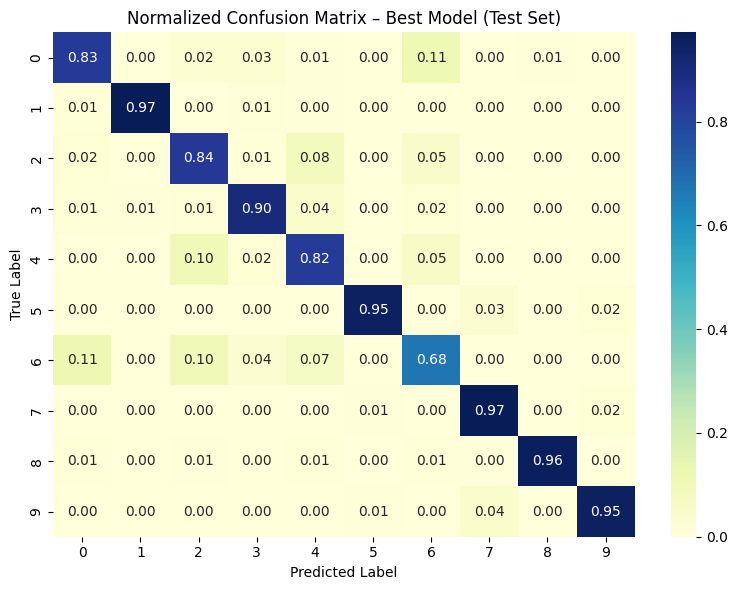

class_0_accuracy,▁
class_1_accuracy,▁
class_2_accuracy,▁
class_3_accuracy,▁
class_4_accuracy,▁
class_5_accuracy,▁
class_6_accuracy,▁
class_7_accuracy,▁
class_8_accuracy,▁
class_9_accuracy,▁
+6,...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
wandb.init(
    project="fashion-mnist-ffnn",
    config={
        "hidden_layers": [128, 64],
        "optimizer": "adam",
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 64
    }
)
config = wandb.config
(X_train, Y_train), (X_test, Y_test) = get_fa_mnist(flatten=True)
model = NeuralNet(
    input_dim=784,
    hidden_layers=config.hidden_layers,
    output_dim=10,
    optimizer=config.optimizer,
    lr=config.learning_rate
)
model.train(
    X_train,
    Y_train,
    X_test,
    Y_test,
    epochs=config.epochs,
    batch_size=config.batch_size
)
Y_pred_test, _ = model.forward(X_test)
y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(Y_pred_test, axis=1)
test_accuracy = np.mean(y_true == y_pred)
wandb.log({"test_accuracy": test_accuracy})
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1
cm_norm = cm / cm.sum(axis=1, keepdims=True)
wandb.log({
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=y_true,
        preds=y_pred,
        class_names=[str(i) for i in range(10)]
    )
})
class_accuracy = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    wandb.log({f"class_{i}_accuracy": acc})
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix – Best Model (Test Set)")
plt.tight_layout()
plt.show()
wandb.finish()